# Part 5: Building the Multimodal Model

We incorporate our learnings from part 4 into building a Multimodal Model with different processing pathways for the various modalities, and then merge their processed features for the final classification. 

In [2]:
# Import necessary libraries

import os
import sys
import copy
import pickle
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras.api._v2.keras as keras
import keras.backend as K
from keras.optimizers.legacy import Adam
from keras.optimizers import SGD
from keras import callbacks
from keras.models import Model
from keras.layers import Layer, Dense, Input, Activation, Lambda, BatchNormalization, Conv1D, SpatialDropout1D, Add, GlobalAveragePooling1D, LSTM, Dense, concatenate, TimeDistributed, Bidirectional, Dropout, Embedding, Attention, MultiHeadAttention, LayerNormalization, Flatten, Concatenate
from tensorflow.keras.backend import sigmoid
from sklearn.model_selection import KFold
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import tensorflow as tf
from data_load import load_data
from basemodel import BaseModel
import tensorflow as tf

%load_ext autoreload
%autoreload 2

In [4]:
# Load data
train_data, train_label, test_data, test_label, train_text, train_audio, train_visual, test_text, test_audio, test_visual = load_data()

Number of training samples:  120
Number of testing samples:  31
Max length of sequences:  110

No. of samples per class: {'neu': 1708, 'fru': 1849, 'ang': 1103, 'sad': 1084, 'exc': 1041, 'hap': 648}

Train text shape: 120 samples, 110 timesteps, 100 features
Train audio shape: 120 samples, 110 timesteps, 100 features
Train visual shape: 120 samples, 110 timesteps, 512 features

Test text shape: 31 samples, 110 timesteps, 100 features
Test audio shape: 31 samples, 110 timesteps, 100 features
Test visual shape: 31 samples, 110 timesteps, 512 features



## Transformer Block and Cross-Modal Attention

In [8]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)
        self.ffn = tf.keras.Sequential([
            Dense(dff, activation='relu'),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.mha(inputs, inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

class CrossModalAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.multi_head_attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)
    
    def call(self, query, key_value):
        attn_output = self.multi_head_attn(query, key_value, key_value)
        return attn_output

## Multimodal model with cross-modal attention

This model processes the individual modalities through different pathways. Then, it uses cross-modal attention layers to study the dependencies between text and video, and text and audio, prioritising text as the most important modality.

In [21]:
# General Multimodal model that uses Cross-Modal Attention
class MultimodalModel(Model):
    def __init__(self, num_classes, d_model=128, num_heads=4):
        super(MultimodalModel, self).__init__()
        
        # Text Pathway - Bi-LSTM with Attention
        self.text_bi_lstm1 = Bidirectional(LSTM(64, return_sequences=True))
        self.text_bi_lstm2 = Bidirectional(LSTM(128, return_sequences=True))
        self.text_dropout = Dropout(0.5)
        self.text_dense = Dense(64, activation='relu')
        
        # Audio Pathway - CNN with Attention
        self.audio_conv1 = Conv1D(32, kernel_size=10, activation='relu', padding='same')
        self.audio_conv2 = Conv1D(64, kernel_size=9, activation='relu', padding='same')
        self.audio_conv3 = Conv1D(100, kernel_size=8, activation='relu', padding='same')
        self.audio_dense = Dense(64, activation='relu')
        
        # Video Pathway - Similar to Audio
        self.video_conv1 = Conv1D(32, kernel_size=10, activation='relu', padding='same')
        self.video_conv2 = Conv1D(64, kernel_size=9, activation='relu', padding='same')
        self.video_conv3 = Conv1D(100, kernel_size=8, activation='relu', padding='same')
        self.video_dense = Dense(64, activation='relu')

        # Cross-modal attention layers
        self.text_audio_attention = CrossModalAttentionLayer(d_model=d_model, num_heads=num_heads)
        self.text_video_attention = CrossModalAttentionLayer(d_model=d_model, num_heads=num_heads)

        # Final processing and classification layers
        self.concat = Concatenate()
        self.global_pool = GlobalAveragePooling1D()
        self.classifier = Dense(num_classes, activation='softmax')
        
    def call(self, inputs, training=False):
        text_inputs, audio_inputs, video_inputs = inputs
        
        # Text Pathway
        x_text = self.text_bi_lstm1(text_inputs)
        x_text = self.text_bi_lstm2(x_text)
        x_text = self.text_dropout(x_text, training=training)
        x_text = self.text_dense(x_text)
        
        # Audio Pathway
        x_audio = self.audio_conv1(audio_inputs)
        x_audio = self.audio_conv2(x_audio)
        x_audio = self.audio_conv3(x_audio)
        x_audio = self.audio_dense(x_audio)
        
        # Video Pathway
        x_video = self.video_conv1(video_inputs)
        x_video = self.video_conv2(x_video)
        x_video = self.video_conv3(x_video)
        x_video = self.video_dense(x_video)

        # Apply cross-modal attention between audio-video and text-video
        text_audio_attn = self.text_audio_attention(x_text, x_audio)
        text_video_attn = self.text_video_attention(x_text, x_video)
        
        # Combine features from both attention mechanisms
        combined_features = self.concat([x_text, text_audio_attn, text_video_attn])
        outputs = self.final_classifier(combined_features)

        # Return the final prediction
        return outputs
    
    def evaluate(self, x_test, y_test):
        predictions = self.predict(x_test)
        y_pred = np.argmax(predictions, axis=-1).flatten()
        y_true = np.argmax(y_test, axis=-1).flatten()

        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

        self.test_metrics =  {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'cm': confusion_matrix(y_true, y_pred)
        }
    
    def print_metrics(self):
        print("Test Metrics:")
        print(f"Accuracy: {self.test_metrics['accuracy']:.4f}")
        # print(f"Precision: {metrics['precision']:.4f}")
        # print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {self.test_metrics['f1_score']:.4f}")

        class_labels = ['hap', 'sad', 'neu', 'ang', 'exc', 'fru']
        print("Confusion Matrix:")
        plt.figure(figsize=(8,6))
        sns.heatmap(self.test_metrics['cm'], annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

Epoch 1/10


2024-04-12 15:38:42.367902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 15:38:42.855474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 15:38:42.877536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 15:38:43.029756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 15:38:43.045464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 15:38:43.410079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 15:38:43.437080: I tensorflow/core/grappler/optimizers/cust

4/4 [==============================] - 4s 256ms/step - loss: 1.5586 - accuracy: 0.4737
Epoch 2/10
4/4 [==============================] - 1s 147ms/step - loss: 1.2101 - accuracy: 0.6573
Epoch 3/10
4/4 [==============================] - 1s 132ms/step - loss: 0.8916 - accuracy: 0.7360
Epoch 4/10
4/4 [==============================] - 0s 128ms/step - loss: 0.7597 - accuracy: 0.7428
Epoch 5/10
4/4 [==============================] - 1s 124ms/step - loss: 0.6339 - accuracy: 0.7622
Epoch 6/10
4/4 [==============================] - 0s 121ms/step - loss: 0.5729 - accuracy: 0.7713
Epoch 7/10
4/4 [==============================] - 0s 116ms/step - loss: 0.5498 - accuracy: 0.7845
Epoch 8/10
4/4 [==============================] - 0s 110ms/step - loss: 0.5121 - accuracy: 0.7886
Epoch 9/10
4/4 [==============================] - 0s 105ms/step - loss: 0.4918 - accuracy: 0.7958
Epoch 10/10
4/4 [==============================] - 0s 109ms/step - loss: 0.4805 - accuracy: 0.8044


2024-04-12 15:38:49.499271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 15:38:49.664846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 15:38:49.664862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 819ms/step


2024-04-12 15:38:49.820082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 15:38:49.830883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test Metrics:
Accuracy: 0.7525
F1 Score: 0.5842
Confusion Matrix:


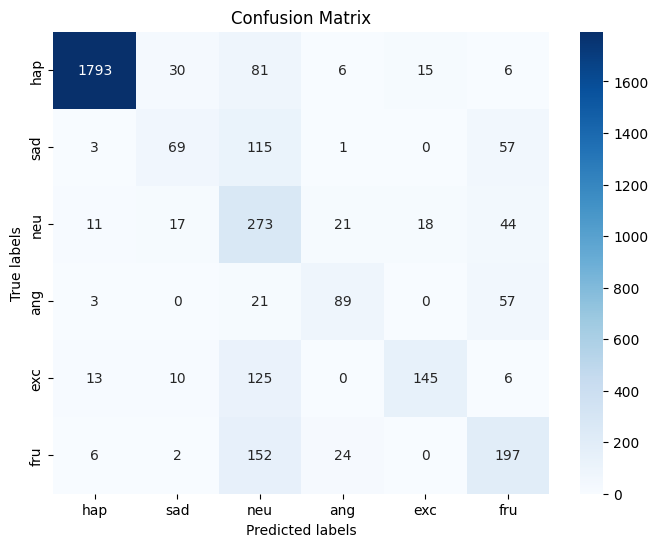

In [20]:
# Instantiate the model
multimodal_model = MultimodalModel(num_classes=6)

# Compile the model
multimodal_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
multimodal_model.fit([train_audio, train_text, train_visual], train_label, epochs=10, batch_size=32)

# Evaluate the model
multimodal_model.evaluate([test_audio, test_text, test_visual], test_label)

# Print the metrics
multimodal_model.print_metrics()

## Multimodal Attention Model

This model first adds a layer of self-attention for each modality, before processing the individual modalities through different pathways. Then, similar to above, it uses cross-modal attention layers to study the dependencies between text and video, and text and audio, prioritising text as the most important modality.

In [16]:
class MultimodalAttentionModel(Model):
    def __init__(self, num_classes, d_model=128, num_heads=4):
        super(MultimodalAttentionModel, self).__init__()
        
        # Text Pathway - Bi-LSTM with Attention
        self.text_attention = MultiHeadAttention(num_heads=4, key_dim=d_model // num_heads)
        self.text_bi_lstm1 = Bidirectional(LSTM(64, return_sequences=True))
        self.text_bi_lstm2 = Bidirectional(LSTM(64, return_sequences=True))
        self.text_dropout = Dropout(0.5)
        self.text_dense = Dense(100, activation='relu')
        
        # Audio Pathway - CNN with Attention
        self.audio_attention = MultiHeadAttention(num_heads=8, key_dim=d_model // num_heads)
        self.audio_conv1 = Conv1D(100, kernel_size=10, activation='relu', padding='same')
        self.audio_conv2 = Conv1D(100, kernel_size=9, activation='relu', padding='same')
        self.audio_conv3 = Conv1D(100, kernel_size=8, activation='relu', padding='same')
        self.audio_dense = Dense(100, activation='relu')
        
        # Video Pathway - Similar to Audio
        self.video_attention = MultiHeadAttention(num_heads=8, key_dim=d_model // num_heads)
        self.video_conv1 = Conv1D(100, kernel_size=10, activation='relu', padding='same')
        self.video_conv2 = Conv1D(100, kernel_size=9, activation='relu', padding='same')
        self.video_conv3 = Conv1D(100, kernel_size=8, activation='relu', padding='same')
        self.video_dense = Dense(100, activation='relu')
        
        # Integration and Classification
        self.concat = Concatenate()
        self.global_pool = GlobalAveragePooling1D()
        self.final_classifier = Dense(num_classes, activation='softmax')

        # Cross-modal attention layers
        self.text_audio_attention = CrossModalAttentionLayer(d_model=d_model, num_heads=num_heads)
        self.text_video_attention = CrossModalAttentionLayer(d_model=d_model, num_heads=num_heads)

        # Final processing and classification layers
        self.concat = Concatenate()
        self.global_pool = GlobalAveragePooling1D()
        self.classifier = Dense(num_classes, activation='softmax')
        
    def call(self, inputs, training=False):
        text_inputs, audio_inputs, video_inputs = inputs
        
        # Text Pathway
        x_text = self.text_attention(text_inputs, text_inputs)
        x_text = self.text_bi_lstm1(text_inputs)
        x_text = self.text_bi_lstm2(x_text)
        x_text = self.text_dropout(x_text, training=training)
        x_text = self.text_dense(x_text)
        
        # Audio Pathway
        x_audio = self.audio_attention(audio_inputs, audio_inputs)
        x_audio = self.audio_conv1(audio_inputs)
        x_audio = self.audio_conv2(x_audio)
        x_audio = self.audio_conv3(x_audio)
        x_audio = self.audio_dense(x_audio)
        
        # Video Pathway
        x_video = self.video_attention(video_inputs, video_inputs)
        x_video = self.video_conv1(video_inputs)
        x_video = self.video_conv2(x_video)
        x_video = self.video_conv3(x_video)
        x_video = self.video_dense(x_video)

        # Apply cross-modal attention between audio-video and text-video
        text_audio_attn = self.text_audio_attention(x_text, x_audio)
        text_video_attn = self.text_video_attention(x_text, x_video)
        
        # Combine features from both attention mechanisms
        combined_features = self.concat([x_text, text_audio_attn, text_video_attn])
        outputs = self.final_classifier(combined_features)

        # Return the final prediction
        return outputs
    
    def evaluate(self, x_test, y_test):
        predictions = self.predict(x_test)
        y_pred = np.argmax(predictions, axis=-1).flatten()
        y_true = np.argmax(y_test, axis=-1).flatten()

        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

        self.test_metrics =  {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'cm': confusion_matrix(y_true, y_pred)
        }

    def print_metrics(self):
        print("Test Metrics:")
        print(f"Accuracy: {self.test_metrics['accuracy']:.4f}")
        # print(f"Precision: {metrics['precision']:.4f}")
        # print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {self.test_metrics['f1_score']:.4f}")

        class_labels = ['hap', 'sad', 'neu', 'ang', 'exc', 'fru']
        print("Confusion Matrix:")
        plt.figure(figsize=(8,6))
        sns.heatmap(self.test_metrics['cm'], annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

Epoch 1/10


2024-04-12 15:35:22.403535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 15:35:22.919407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 15:35:22.943307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 15:35:23.064071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 15:35:23.079818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 15:35:23.368086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 15:35:23.416825: I tensorflow/core/grappler/optimizers/cust

4/4 [==============================] - 4s 224ms/step - loss: 1.6213 - accuracy: 0.4648
Epoch 2/10
4/4 [==============================] - 1s 123ms/step - loss: 1.2732 - accuracy: 0.6148
Epoch 3/10
4/4 [==============================] - 1s 140ms/step - loss: 0.9233 - accuracy: 0.6650
Epoch 4/10
4/4 [==============================] - 1s 128ms/step - loss: 0.7512 - accuracy: 0.7373
Epoch 5/10
4/4 [==============================] - 1s 116ms/step - loss: 0.6097 - accuracy: 0.7528
Epoch 6/10
4/4 [==============================] - 0s 120ms/step - loss: 0.5582 - accuracy: 0.7817
Epoch 7/10
4/4 [==============================] - 0s 121ms/step - loss: 0.5352 - accuracy: 0.7892
Epoch 8/10
4/4 [==============================] - 0s 111ms/step - loss: 0.5058 - accuracy: 0.7970
Epoch 9/10
4/4 [==============================] - 0s 118ms/step - loss: 0.4834 - accuracy: 0.7994
Epoch 10/10
4/4 [==============================] - 0s 118ms/step - loss: 0.4683 - accuracy: 0.8052


2024-04-12 15:35:29.398582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 15:35:29.570765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 15:35:29.598645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 924ms/step


2024-04-12 15:35:29.726450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 15:35:29.737262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test Metrics:
Accuracy: 0.7848
F1 Score: 0.6377
Confusion Matrix:


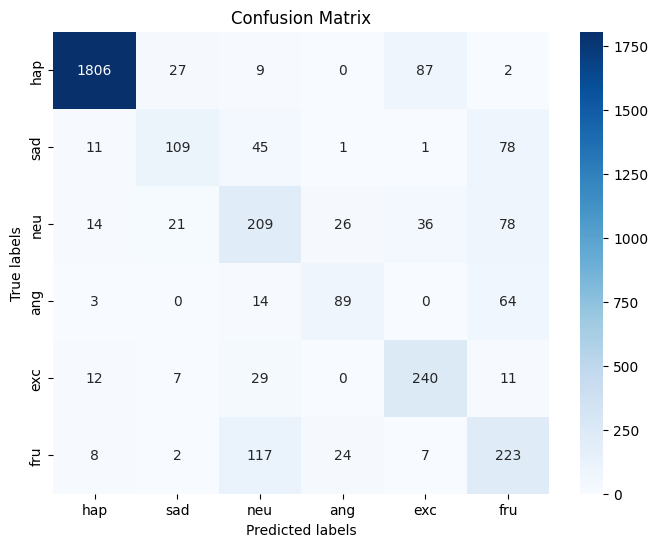

In [17]:
# Instantiate the model
multimodal_attention_model = MultimodalAttentionModel(num_classes=6)

# Compile the model
multimodal_attention_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
multimodal_attention_model.fit([train_audio, train_text, train_visual], train_label, epochs=10, batch_size=32)

# Evaluate the model
multimodal_attention_model.evaluate([test_audio, test_text, test_visual], test_label)

# Print the metrics
multimodal_attention_model.print_metrics()

## Multimodal Transformer Model

This model applies less processing to the individual modalities. Video features are processed through a transformer block and their dimensionality is reduced. Again, cross-modal attention is used.

In [14]:
class MultimodalTransformerModel(Model):
    def __init__(self, d_model, num_heads, dff, rate=0.1, num_classes=10):
        super(MultimodalTransformerModel, self).__init__()
        # Transformer block for processing video features
        self.video_transformer = TransformerBlock(d_model=512, num_heads=8, dff=dff, rate=rate)
        
        # Reducing dimensionality of processed video features to align with audio and text features
        self.dimensionality_reduction = Dense(d_model)
        
        # Text feature processing using bi-LSTM
        self.text_lstm = Bidirectional(LSTM(50, return_sequences=True))

        # Audio feature processing using 1D CNN with padding
        self.audio_cnn = Conv1D(filters=100, kernel_size=3, activation='relu', padding='same')

        # Cross-modal attention layers
        self.text_audio_attention = CrossModalAttentionLayer(d_model=d_model, num_heads=num_heads)
        self.text_video_attention = CrossModalAttentionLayer(d_model=d_model, num_heads=num_heads)

        # Final processing and classification layers
        self.concat = Concatenate()
        self.classifier = Dense(num_classes, activation='softmax')

    def call(self, inputs, training):
        audio_features, text_features, video_features = inputs
        
        # Process video features and reduce dimensionality
        video_features_transformed = self.video_transformer(video_features, training=training)
        video_features_reduced = self.dimensionality_reduction(video_features_transformed)

        # Process text features
        text_features = self.text_lstm(text_features)

        # Process audio features
        audio_features = self.audio_cnn(audio_features)
        
        # Apply cross-modal attention between audio-video and text-video
        text_audio_attn = self.text_audio_attention(text_features, audio_features)
        text_video_attn = self.text_video_attention(text_features, video_features_reduced)
        
        # Combine features from both attention mechanisms
        combined_features = self.concat([text_features, text_audio_attn, text_video_attn])
        outputs = self.classifier(combined_features)

        # Return the final prediction
        return outputs
    
    def evaluate(self, x_test, y_test):
        predictions = self.predict(x_test)
        y_pred = np.argmax(predictions, axis=-1).flatten()
        y_true = np.argmax(y_test, axis=-1).flatten()

        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

        self.test_metrics =  {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'cm': confusion_matrix(y_true, y_pred)
        }

    def print_metrics(self):
        print("Test Metrics:")
        print(f"Accuracy: {self.test_metrics['accuracy']:.4f}")
        # print(f"Precision: {metrics['precision']:.4f}")
        # print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {self.test_metrics['f1_score']:.4f}")

        class_labels = ['hap', 'sad', 'neu', 'ang', 'exc', 'fru']
        print("Confusion Matrix:")
        plt.figure(figsize=(8,6))
        sns.heatmap(self.test_metrics['cm'], annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

Epoch 1/50


2024-04-12 16:34:18.051269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 16:34:18.650766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 16:34:18.672232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 16:34:20.268099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 16:34:20.292430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 9s 1s/step - loss: 1.3894 - accuracy: 0.6139
Epoch 2/50
4/4 [==============================] - 2s 530ms/step - loss: 0.9878 - accuracy: 0.6061
Epoch 3/50
4/4 [==============================] - 2s 425ms/step - loss: 0.7761 - accuracy: 0.7173
Epoch 4/50
4/4 [==============================] - 2s 372ms/step - loss: 0.6088 - accuracy: 0.8177
Epoch 5/50
4/4 [==============================] - 1s 319ms/step - loss: 0.4453 - accuracy: 0.9090
Epoch 6/50
4/4 [==============================] - 1s 287ms/step - loss: 0.2835 - accuracy: 0.9466
Epoch 7/50
4/4 [==============================] - 1s 275ms/step - loss: 0.1707 - accuracy: 0.9574
Epoch 8/50
4/4 [==============================] - 1s 213ms/step - loss: 0.1456 - accuracy: 0.9591
Epoch 9/50
4/4 [==============================] - 1s 246ms/step - loss: 0.1337 - accuracy: 0.9608
Epoch 10/50
4/4 [==============================] - 1s 230ms/step - loss: 0.1208 - accuracy: 0.9641
Epoch 11/50
4/4 [================

2024-04-12 16:35:10.410650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 16:35:10.548170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 16:35:10.576325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step
Test Metrics:
Accuracy: 0.7842
F1 Score: 0.6350
Confusion Matrix:


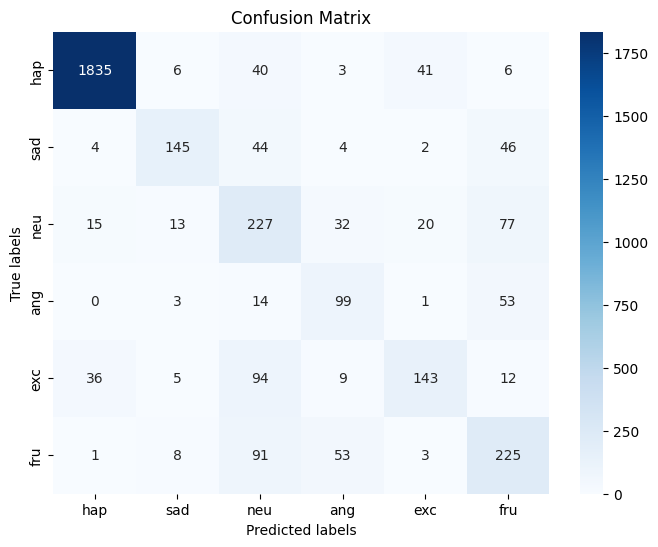

In [72]:
# Instantiate the model
multimodal_transformer_model = MultimodalTransformerModel(d_model=100, num_heads=4, dff=2048, rate=0.1, num_classes=6)

# Compile the model
multimodal_transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
multimodal_transformer_model.fit([train_audio, train_text, train_visual], train_label, epochs=50, batch_size=32)

# Evaluate the model
multimodal_transformer_model.evaluate([test_audio, test_text, test_visual], test_label)

# Print the metrics
multimodal_transformer_model.print_metrics()

## TIMNet Multimodal Model

The models below incorporate TIMNet as part of their architecture. Different architectures are explored to find the optimal one.

In [86]:
class TemporalAwareBlock(Layer):
    def __init__(self, nb_filters, kernel_size, dilation_rate, activation, dropout_rate, name=''):
        super(TemporalAwareBlock, self).__init__(name=name)
        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        
        # Primary layers used in each temporal block
        self.conv1 = Conv1D(filters=nb_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='causal')
        self.norm1 = BatchNormalization()
        self.act1 = Activation(activation)
        self.dropout1 = SpatialDropout1D(dropout_rate)

        self.conv2 = Conv1D(filters=nb_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='causal')
        self.norm2 = BatchNormalization()
        self.act2 = Activation(activation)
        self.dropout2 = SpatialDropout1D(dropout_rate)
        
        # Additional Conv1D layer for matching dimensions if needed
        self.dim_match_conv = Conv1D(filters=nb_filters, kernel_size=1, padding='same')

    def call(self, inputs):
        original_x = inputs

        x = self.conv1(inputs)
        x = self.norm1(x)
        x = self.act1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.act2(x)
        output_2_1 = self.dropout2(x)

        # Check and apply dimension matching if necessary
        if original_x.shape[-1] != output_2_1.shape[-1]:
            original_x = self.dim_match_conv(original_x)

        # Applying sigmoid and element-wise multiplication
        output_2_1 = Lambda(sigmoid)(output_2_1)
        F_x = Lambda(lambda x: tf.multiply(x[0], x[1]))([original_x, output_2_1])
        return F_x


class TIMNET(Model):
    def __init__(self, nb_filters=64, kernel_size=2, nb_stacks=1, dilations=None, activation="relu", dropout_rate=0.1, return_sequences=True, name='TIMNET'):
        super(TIMNET, self).__init__(name=name)
        self.nb_stacks = nb_stacks
        self.dilations = dilations or [1, 2, 4, 8]
        self.forward_blocks = []
        self.backward_blocks = []

        for _ in range(nb_stacks):
            for dilation in self.dilations:
                self.forward_blocks.append(TemporalAwareBlock(nb_filters, kernel_size, dilation, activation, dropout_rate))
                self.backward_blocks.append(TemporalAwareBlock(nb_filters, kernel_size, dilation, activation, dropout_rate))

    def call(self, inputs):
        forward = inputs
        backward = tf.reverse(inputs, axis=[1])  # Assuming the time dimension is axis 1

        final_skip_connections = []

        for forward_block, backward_block in zip(self.forward_blocks, self.backward_blocks):
            skip_out_forward = forward_block(forward)
            skip_out_backward = backward_block(backward)
            # Combine skip outputs from forward and backward blocks at the same level
            temp_skip = Add()([skip_out_forward, skip_out_backward])
            final_skip_connections.append(temp_skip)

        # Combine all skip connections
        if final_skip_connections:
            output = final_skip_connections[0]
            for skip_connection in final_skip_connections[1:]:
                output = concatenate([output, skip_connection], axis=-1)

        return output


1. Using TIMNet on already combined features, similar to initial run of TIMNet. The results are worse than the original TIMNet, but that could be due to less epochs, or other factors.

In [95]:
class MultiModalNet(Model):
    def __init__(self, num_classes=6, d_model=128, num_heads=4):
        super(MultiModalNet, self).__init__()
        # Define pathways for text, audio, and video
        self.timnet = TIMNET(nb_filters=64, kernel_size=3, nb_stacks=2, dilations=[1, 2, 4, 8], activation="relu", dropout_rate=0.2)
        self.concat = Concatenate()
        self.classifier = TimeDistributed(Dense(num_classes, activation='softmax'))


    def call(self, inputs, training=False):
        
        timnet = self.timnet(inputs)

        outputs = self.classifier(timnet)

        return outputs

    def evaluate(self, x_test, y_test):
        predictions = self.predict(x_test)
        y_pred = np.argmax(predictions, axis=-1).flatten()
        y_true = np.argmax(y_test, axis=-1).flatten()

        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

        self.test_metrics =  {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'cm': confusion_matrix(y_true, y_pred)
        }
    
    def print_metrics(self):
        print("Test Metrics:")
        print(f"Accuracy: {self.test_metrics['accuracy']:.4f}")
        # print(f"Precision: {metrics['precision']:.4f}")
        # print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {self.test_metrics['f1_score']:.4f}")

        class_labels = ['hap', 'sad', 'neu', 'ang', 'exc', 'fru']
        print("Confusion Matrix:")
        plt.figure(figsize=(8,6))
        sns.heatmap(self.test_metrics['cm'], annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()


Epoch 1/50


2024-04-12 17:10:57.603762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 86s 34s/step - loss: 3.3494 - accuracy: 0.4907
Epoch 2/50
2/2 [==============================] - 18s 9s/step - loss: 0.7488 - accuracy: 0.9052
Epoch 3/50
2/2 [==============================] - 15s 7s/step - loss: 0.6720 - accuracy: 0.9405
Epoch 4/50
2/2 [==============================] - 13s 5s/step - loss: 0.6629 - accuracy: 0.9468
Epoch 5/50
2/2 [==============================] - 12s 8s/step - loss: 0.6516 - accuracy: 0.9512
Epoch 6/50
2/2 [==============================] - 14s 8s/step - loss: 0.6356 - accuracy: 0.9534
Epoch 7/50
2/2 [==============================] - 9s 3s/step - loss: 0.6218 - accuracy: 0.9553
Epoch 8/50
2/2 [==============================] - 10s 6s/step - loss: 0.6089 - accuracy: 0.9571
Epoch 9/50
2/2 [==============================] - 7s 4s/step - loss: 0.5910 - accuracy: 0.9581
Epoch 10/50
2/2 [==============================] - 7s 2s/step - loss: 0.5764 - accuracy: 0.9589
Epoch 11/50
2/2 [==============================] - 4

2024-04-12 17:15:18.557816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 14s 14s/step
Test Metrics:
Accuracy: 0.7774
F1 Score: 0.6233
Confusion Matrix:


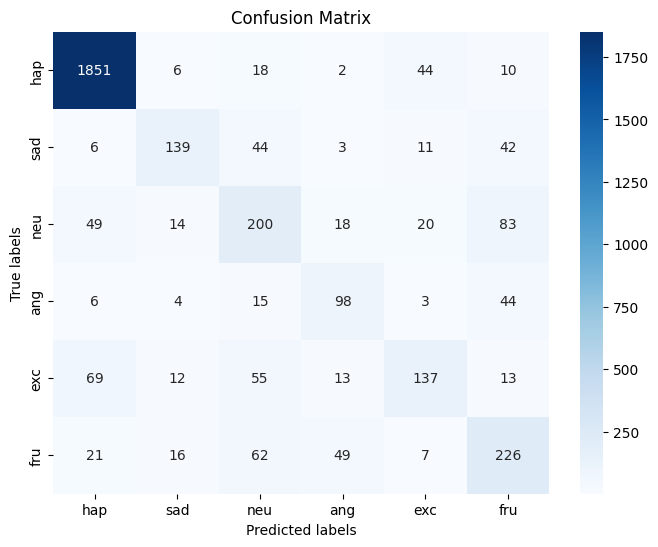

In [97]:
# Instantiate the model
multimodalnet_model = MultiModalNet(num_classes=6)

# Compile the model
multimodalnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
multimodalnet_model.fit(train_data, train_label, epochs=50, batch_size=64)

# Evaluate the model
multimodalnet_model.evaluate(test_data, test_label)

# Print the metrics
multimodalnet_model.print_metrics()

2. Using TIMNet to preprocess individual modalities before applying cross-modal attention. Very slight improvement from the previous one.

In [89]:
class MultiModalNet(Model):
    def __init__(self, num_classes=6, d_model=128, num_heads=4):
        super(MultiModalNet, self).__init__()
        # Define pathways for text, audio, and video
        self.text_timnet = TIMNET(nb_filters=64, kernel_size=3, nb_stacks=2, dilations=[1, 2, 4], activation="relu", dropout_rate=0.2)
        self.audio_timnet = TIMNET(nb_filters=64, kernel_size=3, nb_stacks=2, dilations=[1, 2, 4], activation="relu", dropout_rate=0.2)
        self.video_timnet = TIMNET(nb_filters=64, kernel_size=3, nb_stacks=2, dilations=[1, 2, 4], activation="relu", dropout_rate=0.2)
        
        # Cross modal attention layers
        self.text_audio_attention = CrossModalAttentionLayer(d_model=d_model, num_heads=num_heads)
        self.text_video_attention = CrossModalAttentionLayer(d_model=d_model, num_heads=num_heads)
        
        self.concat = Concatenate()
        self.classifier = TimeDistributed(Dense(num_classes, activation='softmax'))


    def call(self, inputs, training=False):
        text_inputs, audio_inputs, video_inputs = inputs

        x_text = text_inputs
        x_audio = audio_inputs
        x_video = video_inputs

        # TIMNET processing
        x_text = self.text_timnet(x_text)
        x_audio = self.audio_timnet(x_audio)
        x_video = self.video_timnet(x_video)

        # Apply cross-modal attention between audio-video and text-video
        text_audio_attn = self.text_audio_attention(x_text, x_audio)
        text_video_attn = self.text_video_attention(x_text, x_video)

        # Combine and classify
        combined_features = self.concat([x_text, text_audio_attn, text_video_attn])
        outputs = self.classifier(combined_features)

        return outputs

    def evaluate(self, x_test, y_test):
        predictions = self.predict(x_test)
        y_pred = np.argmax(predictions, axis=-1).flatten()
        y_true = np.argmax(y_test, axis=-1).flatten()

        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

        self.test_metrics =  {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'cm': confusion_matrix(y_true, y_pred)
        }
    
    def print_metrics(self):
        print("Test Metrics:")
        print(f"Accuracy: {self.test_metrics['accuracy']:.4f}")
        # print(f"Precision: {metrics['precision']:.4f}")
        # print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {self.test_metrics['f1_score']:.4f}")

        class_labels = ['hap', 'sad', 'neu', 'ang', 'exc', 'fru']
        print("Confusion Matrix:")
        plt.figure(figsize=(8,6))
        sns.heatmap(self.test_metrics['cm'], annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()


Epoch 1/10


2024-04-12 16:54:38.025735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 169s 27s/step - loss: 1.3484 - accuracy: 0.4840
Epoch 2/10
4/4 [==============================] - 53s 13s/step - loss: 1.0205 - accuracy: 0.6546
Epoch 3/10
4/4 [==============================] - 41s 10s/step - loss: 0.7771 - accuracy: 0.7608
Epoch 4/10
4/4 [==============================] - 32s 9s/step - loss: 0.6360 - accuracy: 0.7891
Epoch 5/10
4/4 [==============================] - 28s 7s/step - loss: 0.5365 - accuracy: 0.8072
Epoch 6/10
4/4 [==============================] - 18s 5s/step - loss: 0.4902 - accuracy: 0.8211
Epoch 7/10
4/4 [==============================] - 16s 4s/step - loss: 0.4488 - accuracy: 0.8315
Epoch 8/10
4/4 [==============================] - 11s 3s/step - loss: 0.4299 - accuracy: 0.8265
Epoch 9/10
4/4 [==============================] - 14s 4s/step - loss: 0.4138 - accuracy: 0.8349
Epoch 10/10
4/4 [==============================] - 11s 3s/step - loss: 0.3963 - accuracy: 0.8375


2024-04-12 17:01:00.272274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 25s 25s/step
Test Metrics:
Accuracy: 0.7745
F1 Score: 0.6309
Confusion Matrix:


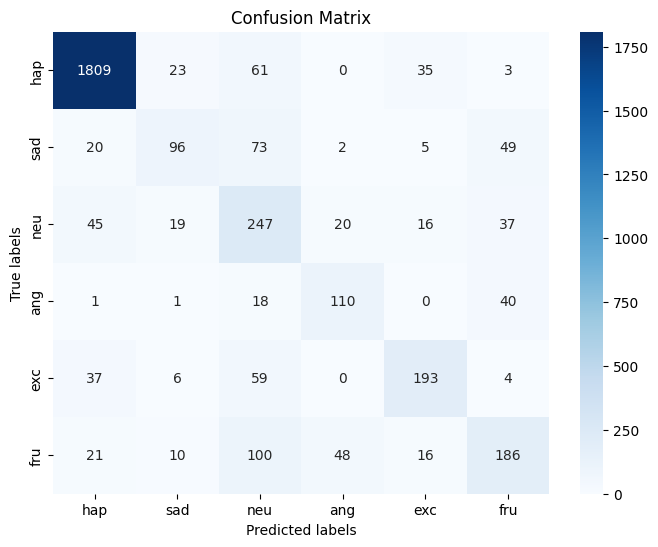

In [90]:
# Instantiate the model
multimodalnet_model = MultiModalNet(num_classes=6)

# Compile the model
multimodalnet_model .compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
multimodalnet_model .fit([train_audio, train_text, train_visual], train_label, epochs=10, batch_size=32)

# Evaluate the model
multimodalnet_model .evaluate([test_audio, test_text, test_visual], test_label)

# Print the metrics
multimodalnet_model.print_metrics()

3. Processing each modality with individual pathways before cross-modal attention, and finally TIMNet on concatenated features

In [91]:
class MultiModalNet(Model):
    def __init__(self, num_classes=6, d_model=128, num_heads=4, nb_filters=64, kernel_size=3, nb_stacks=1, dilations=[1, 2, 4, 8]):
        super(MultiModalNet, self).__init__()
        # Initialize processing layers for each modality
        self.text_lstm = Bidirectional(LSTM(50, return_sequences=True))
        self.audio_cnn = Conv1D(filters=100, kernel_size=3, activation='relu', padding='same')
        self.video_cnn = Conv1D(filters=100, kernel_size=3, activation='relu', padding='same')

        # Cross-modal attention layers
        self.text_audio_attention = CrossModalAttentionLayer(d_model=d_model, num_heads=num_heads)
        self.text_video_attention = CrossModalAttentionLayer(d_model=d_model, num_heads=num_heads)

        # Concatenation layer
        self.concat = Concatenate()

        # TIMNET applied after cross-modal attention
        self.timnet = TIMNET(nb_filters=nb_filters, kernel_size=kernel_size, nb_stacks=nb_stacks, dilations=dilations, activation="relu", dropout_rate=0.1)

        # Classifier
        self.classifier = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        text_inputs, audio_inputs, video_inputs = inputs

        # Process each modality
        x_text = self.text_lstm(text_inputs)
        x_audio = self.audio_cnn(audio_inputs)
        x_video = self.video_cnn(video_inputs)

        # Apply cross-modal attention
        text_audio_attn = self.text_audio_attention(x_text, x_audio)
        text_video_attn = self.text_video_attention(x_text, x_video)

        # Combine features from attention mechanisms
        combined_features = self.concat([x_text, text_audio_attn, text_video_attn])

        # Pass combined features through TIMNET
        processed_features = self.timnet(combined_features)

        # Pool and classify
        outputs = self.classifier(processed_features)
        
        return outputs


    def evaluate(self, x_test, y_test):
        predictions = self.predict(x_test)
        y_pred = np.argmax(predictions, axis=-1).flatten()
        y_true = np.argmax(y_test, axis=-1).flatten()

        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

        self.test_metrics =  {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'cm': confusion_matrix(y_true, y_pred)
        }
    
    def print_metrics(self):
        print("Test Metrics:")
        print(f"Accuracy: {self.test_metrics['accuracy']:.4f}")
        # print(f"Precision: {metrics['precision']:.4f}")
        # print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {self.test_metrics['f1_score']:.4f}")

        class_labels = ['hap', 'sad', 'neu', 'ang', 'exc', 'fru']
        print("Confusion Matrix:")
        plt.figure(figsize=(8,6))
        sns.heatmap(self.test_metrics['cm'], annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()


Epoch 1/10


2024-04-12 17:03:06.093117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 17:03:07.660301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 17:03:07.722695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 17:03:27.176294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 17:03:27.200803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 59s 9s/step - loss: 1.5125 - accuracy: 0.4778
Epoch 2/10
4/4 [==============================] - 15s 4s/step - loss: 0.9682 - accuracy: 0.6953
Epoch 3/10
4/4 [==============================] - 10s 2s/step - loss: 0.7500 - accuracy: 0.7284
Epoch 4/10
4/4 [==============================] - 7s 2s/step - loss: 0.6292 - accuracy: 0.7797
Epoch 5/10
4/4 [==============================] - 6s 2s/step - loss: 0.5315 - accuracy: 0.7889
Epoch 6/10
4/4 [==============================] - 5s 1s/step - loss: 0.4902 - accuracy: 0.8075
Epoch 7/10
4/4 [==============================] - 4s 959ms/step - loss: 0.4503 - accuracy: 0.8159
Epoch 8/10
4/4 [==============================] - 4s 735ms/step - loss: 0.4565 - accuracy: 0.8167
Epoch 9/10
4/4 [==============================] - 2s 695ms/step - loss: 0.4497 - accuracy: 0.8131
Epoch 10/10
4/4 [==============================] - 2s 553ms/step - loss: 0.4468 - accuracy: 0.8155


2024-04-12 17:04:52.327566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 17:04:52.948743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-12 17:04:52.963173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 7s 7s/step
Test Metrics:
Accuracy: 0.7279
F1 Score: 0.5197
Confusion Matrix:


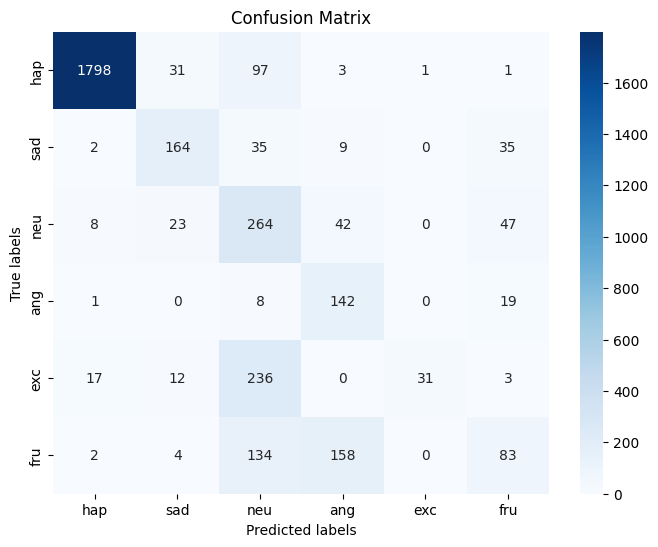

In [92]:
# Instantiate the model
multimodalnet_model = MultiModalNet(num_classes=6)

# Compile the model
multimodalnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
multimodalnet_model.fit([train_audio, train_text, train_visual], train_label, epochs=10, batch_size=32)

# Evaluate the model
multimodalnet_model.evaluate([test_audio, test_text, test_visual], test_label)

# Print the metrics
multimodalnet_model.print_metrics()